## Hyades Isochrone

**SIMBAD**  
Coordinates : 04 29 47.3 +16 56 53  
Proper motions mas/yr : 104.92 -28.00  
Parallaxes (mas): 	21.052


Using https://arxiv.org/abs/astro-ph/9707253 for age, metallicity priors.

In [710]:
import astropy
import astroquery
import matplotlib.pyplot as plt
from astroquery.utils.tap.core import TapPlus
import pandas as pd
from astropy.coordinates import ICRS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.gaia import Gaia

Gaia.ROW_LIMIT = 10000

max_no = 10000
parallax_lim = [15, 30]
cone_radius = 15 # in degrees
co_str = "4:29:47.3 +16:56:53"

coord = SkyCoord(co_str, frame='icrs', unit=(u.hourangle, u.deg))


job = Gaia.launch_job_async(
    f"""SELECT TOP {max_no} *, phot_g_mean_mag+5*log10(parallax)-10 as mg, \
    DISTANCE( \
   POINT({coord.ra.degree}, {coord.dec.degree}), \
   POINT(ra, dec)) AS ang_sep \
FROM gaiadr3.gaia_source \
WHERE 1 = CONTAINS( \
   POINT({coord.ra.degree}, {coord.dec.degree}), \
   CIRCLE(ra, dec, {cone_radius})) \
AND parallax > {parallax_lim[0]} \
AND parallax < {parallax_lim[1]} \
AND parallax_over_error>10 \
AND phot_g_mean_flux_over_error>50 \
AND phot_rp_mean_flux_over_error>20 \
AND phot_bp_mean_flux_over_error>20 \
AND visibility_periods_used>8
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5) < 1.44 * greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND astrometric_excess_noise < 1
ORDER BY ang_sep ASC;""", dump_to_file=False)

job2 = Gaia.launch_job_async(
    f"""SELECT TOP {max_no} *, phot_g_mean_mag+5*log10(parallax)-10 as mg, \
    DISTANCE( \
   POINT({coord.ra.degree}, {coord.dec.degree}), \
   POINT(ra, dec)) AS ang_sep \
FROM gaiadr3.gaia_source \
WHERE 1 = CONTAINS( \
   POINT({coord.ra.degree}, {coord.dec.degree}), \
   CIRCLE(ra, dec, {cone_radius})) \
AND parallax > {parallax_lim[0]} \
AND parallax < {parallax_lim[1]} \
ORDER BY ang_sep ASC;""", dump_to_file=False)

# NGC 6397 - 17 40 42.09 -53 40 27.6

hyades_stars = job.get_results()
hyades_no_quality = job2.get_results()

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [711]:
print("Total Stars: ", len(hyades_stars))
print("Total Stars Before Quality Cuts: ", len(hyades_no_quality))

Total Stars:  1535
Total Stars Before Quality Cuts:  2067


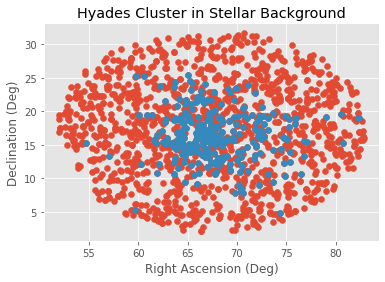

In [712]:
para_min = 19
para_max = 24
pmra_min = 65
pmra_max = 125
pmdec_min = -50
pmdec_max = 0

hyades_parallax = hyades_stars[(hyades_stars['parallax'] > para_min) & (hyades_stars['parallax'] < para_max)]
hyades_pm = hyades_stars[(hyades_stars['pmra'] > pmra_min) & (hyades_stars['pmra'] < pmra_max) 
                         & (hyades_stars['pmdec'] > pmdec_min) & (hyades_stars['pmdec'] < pmdec_max)]
hyades_final = hyades_stars[(hyades_stars['parallax'] > para_min) & (hyades_stars['parallax'] < para_max) & 
                            (hyades_stars['pmra'] > pmra_min) & (hyades_stars['pmra'] < pmra_max) &
                            (hyades_stars['pmdec'] > pmdec_min) & (hyades_stars['pmdec'] < pmdec_max)
                              ]
hyades_noq_final = hyades_no_quality[(hyades_no_quality['parallax'] > para_min) & (hyades_no_quality['parallax'] < para_max) & 
                            (hyades_no_quality['pmra'] > pmra_min) & (hyades_no_quality['pmra'] < pmra_max) &
                            (hyades_no_quality['pmdec'] > pmdec_min) & (hyades_no_quality['pmdec'] < pmdec_max)]

plt.scatter(hyades_stars['ra'], hyades_stars['dec'])
plt.scatter(hyades_final['ra'], hyades_final['dec'])
plt.title("Hyades Cluster in Stellar Background")
plt.xlabel("Right Ascension (Deg)")
plt.ylabel("Declination (Deg)")
plt.savefig("onsky_hyades", bbox_inches = 'tight')

In [713]:
" & ".join(str(x) for x in ["Hyades"] + co_str.split(" ") + [cone_radius] + [parallax_lim] + [[para_min, para_max]] + [[pmra_min, pmra_max]] + [[pmdec_min, pmdec_max]]) + "\\"

'Hyades & 4:29:47.3 & +16:56:53 & 15 & [15, 30] & [19, 24] & [65, 125] & [-50, 0]\\'

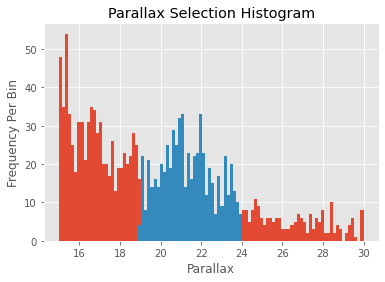

In [714]:
bins = plt.hist(hyades_stars['parallax'], bins = 100)
plt.hist(hyades_parallax['parallax'], bins = bins[1])
plt.title("Parallax Selection Histogram")
plt.xlabel("Parallax")
plt.ylabel("Frequency Per Bin")
plt.savefig("para_hyades", bbox_inches = 'tight')

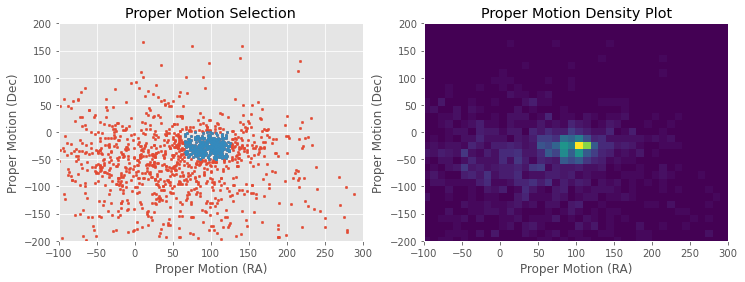

In [715]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].scatter(hyades_stars['pmra'],hyades_stars['pmdec'], s = 6)
ax[0].scatter(hyades_pm['pmra'], hyades_pm['pmdec'], s = 6)
ax[0].set_title("Proper Motion Selection")
ax[0].set_xlabel("Proper Motion (RA)")
ax[0].set_ylabel("Proper Motion (Dec)")
ax[0].set_xlim((-100, 300))
ax[0].set_ylim((-200, 200))
ax[1].hist2d(hyades_stars['pmra'],hyades_stars['pmdec'], bins = 100)
ax[1].sharey(ax[0])
ax[1].sharex(ax[0])
ax[1].set_title("Proper Motion Density Plot")
ax[1].set_xlabel("Proper Motion (RA)")
ax[1].set_ylabel("Proper Motion (Dec)")
plt.savefig("pm_hyades", bbox_inches = 'tight')

In [716]:
print("Total Stars Post All Cuts: ", len(hyades_final))

Total Stars Post All Cuts:  283


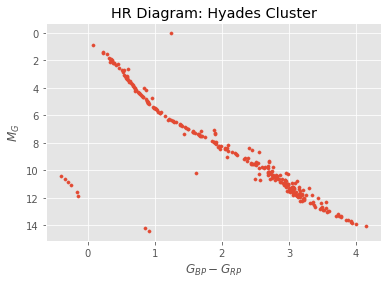

In [717]:
plt.style.use('ggplot')
#plt.scatter(hyades_noq_final['bp_g'] - hyades_noq_final['g_rp'], hyades_noq_final['mg'], s = 10)
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 10)
plt.gca().invert_yaxis()
plt.title("HR Diagram: Hyades Cluster")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.savefig("hr_hyades", bbox_inches = 'tight')

Text(0, 0.5, '$M_G$')

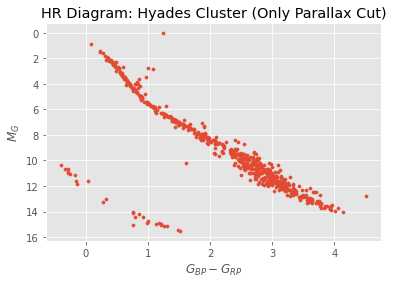

In [718]:
plt.style.use('ggplot')
#plt.scatter(hyades_noq_final['bp_g'] - hyades_noq_final['g_rp'], hyades_noq_final['mg'], s = 10)
plt.scatter(hyades_parallax['bp_rp'], hyades_parallax['mg'], s = 10)
plt.gca().invert_yaxis()
plt.title("HR Diagram: Hyades Cluster (Only Parallax Cut)")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")

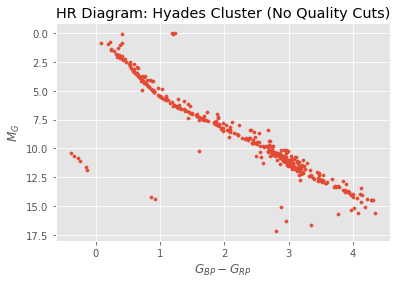

In [719]:
plt.style.use('ggplot')
plt.scatter(hyades_noq_final['bp_rp'], hyades_noq_final['mg'], s = 10)
plt.gca().invert_yaxis()
plt.title("HR Diagram: Hyades Cluster (No Quality Cuts)")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.savefig("noquality_hyades", bbox_inches = 'tight')

In [720]:
import read_mist_models
import matplotlib.pyplot as plt
import numpy as np

isocmd_list = []
for i in np.arange(10, 60, 10):
    isocmd_list.append(read_mist_models.ISOCMD(f'hyades_m{i}.iso.cmd'))

Reading in: hyades_m10.iso.cmd
Reading in: hyades_m20.iso.cmd
Reading in: hyades_m30.iso.cmd
Reading in: hyades_m40.iso.cmd
Reading in: hyades_m50.iso.cmd


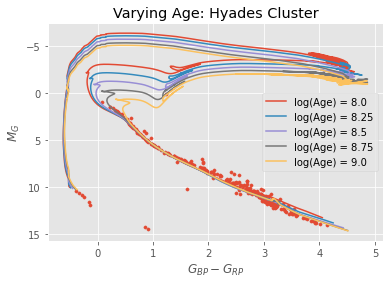

In [721]:
isocmd = isocmd_list[2]
for i in np.linspace(8.0, 9.0, 5):
    age_ind = isocmd.age_index(i) #returns the index for the desired age
    G = isocmd.isocmds[age_ind]['Gaia_G_EDR3']
    B = isocmd.isocmds[age_ind]['Gaia_BP_EDR3']
    V = isocmd.isocmds[age_ind]['Gaia_RP_EDR3']
    plt.plot(B-V, G, label = f"log(Age) = {i}") 
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 10)
plt.title("Varying Age: Hyades Cluster")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.legend()
plt.gca().invert_yaxis()
plt.savefig("age_mist_hyades", bbox_inches = 'tight')

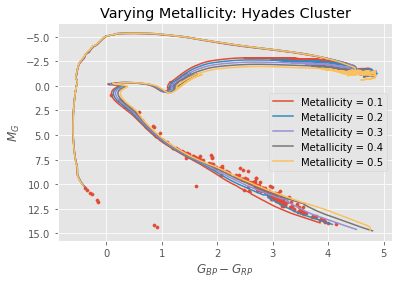

In [722]:
for i in range(5):
    isocmd = isocmd_list[i]
    age_ind = isocmd.age_index(8.75) #returns the index for the desired age
    G = isocmd.isocmds[age_ind]['Gaia_G_EDR3']
    B = isocmd.isocmds[age_ind]['Gaia_BP_EDR3']
    V = isocmd.isocmds[age_ind]['Gaia_RP_EDR3']
    plt.plot(B-V, G, label = f"Metallicity = {round(0.1 + i/10, 1)}") 
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 10)
plt.title("Varying Metallicity: Hyades Cluster")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.legend()
plt.gca().invert_yaxis()
plt.savefig("metal_mist_hyades", bbox_inches = 'tight')

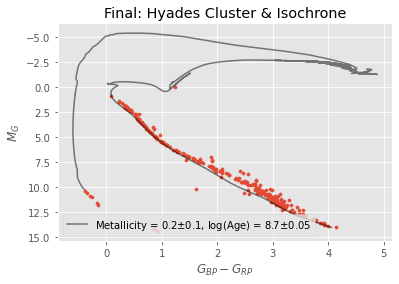

In [723]:
isocmd = isocmd_list[1]
age = 8.7
age_ind = isocmd.age_index(age)
G = isocmd.isocmds[age_ind]['Gaia_G_EDR3']
B = isocmd.isocmds[age_ind]['Gaia_BP_EDR3']
V = isocmd.isocmds[age_ind]['Gaia_RP_EDR3']
plt.plot(B-V, G, label = f"Metallicity = {round(0.2, 1)}$\pm$0.1, log(Age) = {age}$\pm$0.05", c = "k", alpha = 0.5) 
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 10)
plt.title("Final: Hyades Cluster & Isochrone")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.gca().invert_yaxis()
plt.legend()
plt.savefig("mist_final_hyades", bbox_inches = 'tight')

In [724]:
from astropy.table import Table
parsec_iso = Table.read('parsec_hyades.txt', format='ascii', header_start=13)
parsec_iso = parsec_iso[(parsec_iso["G_BPmag"]-parsec_iso["G_RPmag"] >= 2) | (parsec_iso["Gmag"] <= 25)]

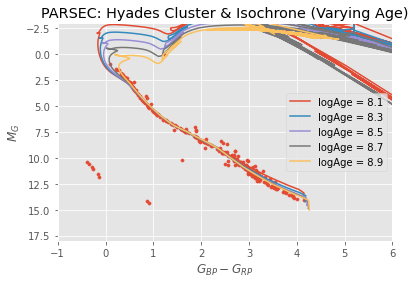

In [725]:
for i in pd.Series(parsec_iso["logAge"]).unique()[1::2]:
    z_parsec = parsec_iso[(parsec_iso["Zini"] == pd.Series(parsec_iso["Zini"]).unique()[2]) & (parsec_iso["logAge"] == i)]
    plt.plot(z_parsec["G_BPmag"]-z_parsec["G_RPmag"], z_parsec["Gmag"], label = f"logAge = {np.round(i, 2)}")
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 10)
plt.title("PARSEC: Hyades Cluster & Isochrone (Varying Age)")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.xlim((-1, 6))
plt.ylim((-3, 18))
plt.legend()
plt.gca().invert_yaxis()
plt.savefig("age_parsec_hyades", bbox_inches = 'tight')

In [726]:
pd.Series(parsec_iso["logAge"]).unique()[1::2][3]

8.7

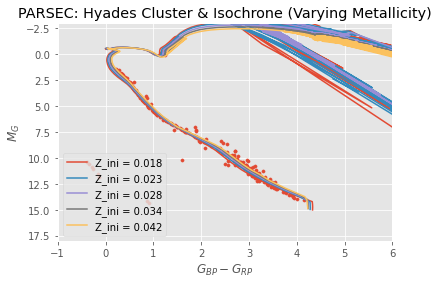

In [727]:
for i in pd.Series(parsec_iso["Zini"]).unique():
    z_parsec = parsec_iso[(parsec_iso["Zini"] == i) & (parsec_iso["logAge"] == 8.7)]
    plt.plot(z_parsec["G_BPmag"]-z_parsec["G_RPmag"], z_parsec["Gmag"], label = f"Z_ini = {np.round(i, 3)}")
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 10)
plt.title("PARSEC: Hyades Cluster & Isochrone (Varying Metallicity)")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.xlim((-1, 6))
plt.ylim((-3, 18))
plt.legend()
plt.gca().invert_yaxis()
plt.savefig("metal_parsec_hyades", bbox_inches = 'tight')

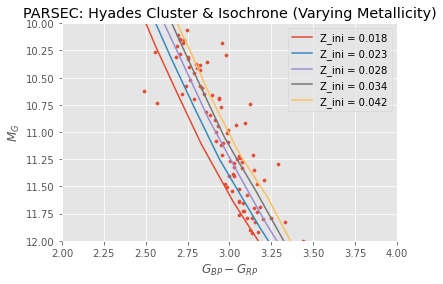

In [728]:
for i in pd.Series(parsec_iso["Zini"]).unique():
    z_parsec = parsec_iso[(parsec_iso["Zini"] == i) & (parsec_iso["logAge"] == 8.7)]
    plt.plot(z_parsec["G_BPmag"]-z_parsec["G_RPmag"], z_parsec["Gmag"], label = f"Z_ini = {np.round(i, 3)}")
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 10)
plt.title("PARSEC: Hyades Cluster & Isochrone (Varying Metallicity)")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.xlim((2, 4))
plt.ylim((10, 12))
plt.legend()
plt.gca().invert_yaxis()
plt.savefig("metal_parsec_hyades_zoom", bbox_inches = 'tight')

In [729]:
pd.Series(parsec_iso["Zini"]).unique()[2]

0.027842

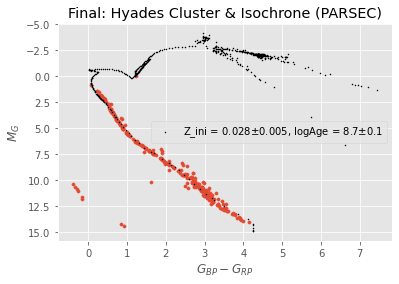

In [730]:
z_parsec = parsec_iso[(parsec_iso["Zini"] == 0.027842) & (parsec_iso["logAge"] == 8.7)]
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 10)
plt.scatter(z_parsec["G_BPmag"]-z_parsec["G_RPmag"], z_parsec["Gmag"], label = f"Z_ini = {0.028}$\pm$0.005, logAge = {8.7}$\pm$0.1", c = "k", s = 1)
plt.title("Final: Hyades Cluster & Isochrone (PARSEC)")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.gca().invert_yaxis()
plt.legend()
plt.savefig("parsec_hyades", bbox_inches = 'tight')

**Cuts made by Babisnaux:**  
  
visibility_periods_used>8  
sqrt(astrometric_chi2_al / (astrometric_n_good_obs_al - 5)) < 1.2 max(1, exp(−0.2(G − 19.5)))  
MG =G + 5 + 5 log10($/1000.)  
parallax_over_error>10  
phot_g_mean_flux_over_error>50  
phot_rp_mean_flux_over_error>20  
phot_bp_mean_flux_over_error>20  
phot_bp_rp_excess_factor> 1.0+0.015 (GBP −GRP)^2  
phot_bp_rp_excess_factor< 1.3 + 0.06 (GBP − GRP)2  

## M67 Isochrone

**SIMBAD**  
Coordinates : 08 51 23.0 +11 48 50  
Proper motions mas/yr : -10.9737 -2.9396
Parallaxes (mas): 	1.1325


In [732]:
import astropy
import astroquery
import matplotlib.pyplot as plt
from astroquery.utils.tap.core import TapPlus
import pandas as pd
from astropy.coordinates import ICRS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.gaia import Gaia

Gaia.ROW_LIMIT = 10000

max_no = 10000
parallax_lim = [0, 3]
cone_radius = 0.5 # in degrees
co_str = "08:51:23.0 +11:48:50"

coord = SkyCoord(co_str, frame='icrs', unit=(u.hourangle, u.deg))


job = Gaia.launch_job_async(
    f"""SELECT TOP {max_no} *, phot_g_mean_mag+5*log10(parallax)-10 as mg, \
    DISTANCE( \
   POINT({coord.ra.degree}, {coord.dec.degree}), \
   POINT(ra, dec)) AS ang_sep \
FROM gaiadr3.gaia_source \
WHERE 1 = CONTAINS( \
   POINT({coord.ra.degree}, {coord.dec.degree}), \
   CIRCLE(ra, dec, {cone_radius})) \
AND parallax > {parallax_lim[0]} \
AND parallax < {parallax_lim[1]} \
AND parallax_over_error>10 \
AND phot_g_mean_flux_over_error>50 \
AND phot_rp_mean_flux_over_error>20 \
AND phot_bp_mean_flux_over_error>20 \
AND visibility_periods_used>8
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5) < 1.44 * greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND astrometric_excess_noise < 1
ORDER BY ang_sep ASC;""", dump_to_file=False)

job2 = Gaia.launch_job_async(
    f"""SELECT TOP {max_no} *, phot_g_mean_mag+5*log10(parallax)-10 as mg, \
    DISTANCE( \
   POINT({coord.ra.degree}, {coord.dec.degree}), \
   POINT(ra, dec)) AS ang_sep \
FROM gaiadr3.gaia_source \
WHERE 1 = CONTAINS( \
   POINT({coord.ra.degree}, {coord.dec.degree}), \
   CIRCLE(ra, dec, {cone_radius})) \
AND parallax > {parallax_lim[0]} \
AND parallax < {parallax_lim[1]} \
ORDER BY ang_sep ASC;""", dump_to_file=False)

# NGC 6397 - 17 40 42.09 -53 40 27.6

hyades_stars = job.get_results()
hyades_no_quality = job2.get_results()

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [733]:
print("Total Stars: ", len(hyades_stars))
print("Total Stars Before Quality Cuts: ", len(hyades_no_quality))

Total Stars:  1608
Total Stars Before Quality Cuts:  4598


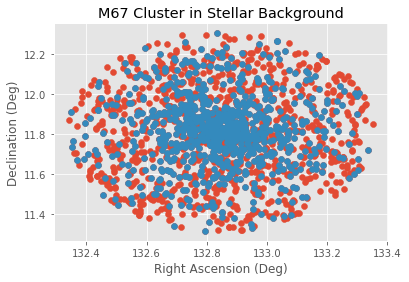

In [734]:
plt.scatter(hyades_stars['ra'], hyades_stars['dec'])

para_min = 1.0
para_max = 1.3
pmra_min = -13
pmra_max = -10
pmdec_min = -3.8
pmdec_max = -2

hyades_parallax = hyades_stars[(hyades_stars['parallax'] > para_min) & (hyades_stars['parallax'] < para_max)]
hyades_pm = hyades_stars[(hyades_stars['pmra'] > pmra_min) & (hyades_stars['pmra'] < pmra_max) 
                         & (hyades_stars['pmdec'] > pmdec_min) & (hyades_stars['pmdec'] < pmdec_max)]
hyades_final = hyades_stars[(hyades_stars['parallax'] > para_min) & (hyades_stars['parallax'] < para_max) & 
                            (hyades_stars['pmra'] > pmra_min) & (hyades_stars['pmra'] < pmra_max) &
                            (hyades_stars['pmdec'] > pmdec_min) & (hyades_stars['pmdec'] < pmdec_max)
                              ]
hyades_noq_final = hyades_no_quality[(hyades_no_quality['parallax'] > para_min) & (hyades_no_quality['parallax'] < para_max) & 
                            (hyades_no_quality['pmra'] > pmra_min) & (hyades_no_quality['pmra'] < pmra_max) &
                            (hyades_no_quality['pmdec'] > pmdec_min) & (hyades_no_quality['pmdec'] < pmdec_max)
                              ]
plt.scatter(hyades_final['ra'], hyades_final['dec'])
plt.title("M67 Cluster in Stellar Background")
plt.xlabel("Right Ascension (Deg)")
plt.ylabel("Declination (Deg)")
plt.savefig("onsky_m67", bbox_inches = 'tight')

In [735]:
" & ".join(str(x) for x in ["M67"] + co_str.split(" ") + [cone_radius] + [parallax_lim] + [[para_min, para_max]] + [[pmra_min, pmra_max]] + [[pmdec_min, pmdec_max]]) + "\\"

'M67 & 08:51:23.0 & +11:48:50 & 0.5 & [0, 3] & [1.0, 1.3] & [-13, -10] & [-3.8, -2]\\'

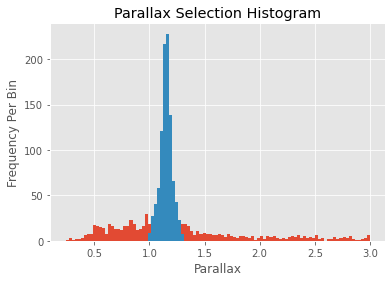

In [736]:
bins = plt.hist(hyades_stars['parallax'], bins = 100)
plt.hist(hyades_parallax['parallax'], bins = bins[1])
plt.title("Parallax Selection Histogram")
plt.xlabel("Parallax")
plt.ylabel("Frequency Per Bin")
plt.savefig("para_m67", bbox_inches = 'tight')

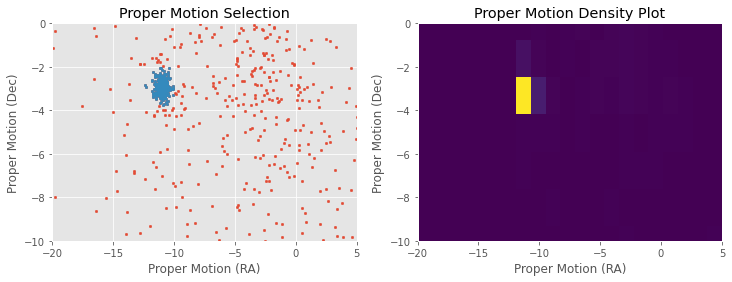

In [737]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].scatter(hyades_stars['pmra'],hyades_stars['pmdec'], s = 6)
ax[0].scatter(hyades_pm['pmra'], hyades_pm['pmdec'], s = 6)
ax[0].set_title("Proper Motion Selection")
ax[0].set_xlabel("Proper Motion (RA)")
ax[0].set_ylabel("Proper Motion (Dec)")
ax[0].set_xlim((-20, 5))
ax[0].set_ylim((-10, 0))
ax[1].hist2d(hyades_stars['pmra'],hyades_stars['pmdec'], bins = 100)
ax[1].sharey(ax[0])
ax[1].sharex(ax[0])
ax[1].set_title("Proper Motion Density Plot")
ax[1].set_xlabel("Proper Motion (RA)")
ax[1].set_ylabel("Proper Motion (Dec)")
plt.savefig("pm_m67", bbox_inches = 'tight')

In [738]:
print("Total Stars Post All Cuts: ", len(hyades_final))

Total Stars Post All Cuts:  839


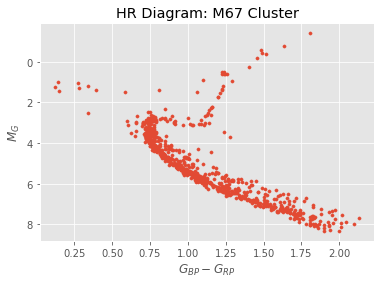

In [739]:
plt.style.use('ggplot')
#plt.scatter(hyades_noq_final['bp_g'] - hyades_noq_final['g_rp'], hyades_noq_final['mg'], s = 10)
#plt.scatter(hyades_final['bp_g'] - hyades_final['g_rp'], hyades_final['mg'], s = 10)
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 10)
plt.gca().invert_yaxis()
plt.title("HR Diagram: M67 Cluster")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.savefig("hr_m67", bbox_inches = 'tight')

Text(0, 0.5, '$M_G$')

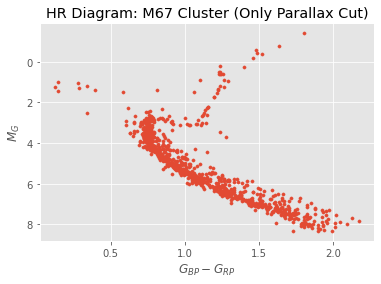

In [740]:
plt.style.use('ggplot')
#plt.scatter(hyades_noq_final['bp_g'] - hyades_noq_final['g_rp'], hyades_noq_final['mg'], s = 10)
plt.scatter(hyades_parallax['bp_rp'], hyades_parallax['mg'], s = 10)
plt.gca().invert_yaxis()
plt.title("HR Diagram: M67 Cluster (Only Parallax Cut)")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")

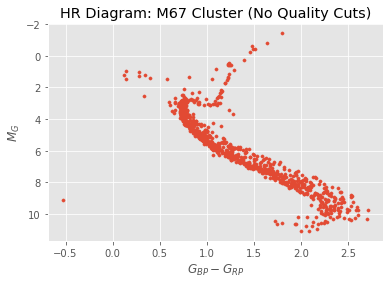

In [741]:
plt.style.use('ggplot')
plt.scatter(hyades_noq_final['bp_rp'], hyades_noq_final['mg'], s = 10)
plt.gca().invert_yaxis()
plt.title("HR Diagram: M67 Cluster (No Quality Cuts)")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.savefig("hr_noquality_m67", bbox_inches = 'tight')

In [742]:
import read_mist_models
import matplotlib.pyplot as plt
import numpy as np

isocmd_list = []
for i in np.arange(-20, 40, 10):
    isocmd_list.append(read_mist_models.ISOCMD(f'm67_m{i}.iso.cmd'))

Reading in: m67_m-20.iso.cmd
Reading in: m67_m-10.iso.cmd
Reading in: m67_m0.iso.cmd
Reading in: m67_m10.iso.cmd
Reading in: m67_m20.iso.cmd
Reading in: m67_m30.iso.cmd


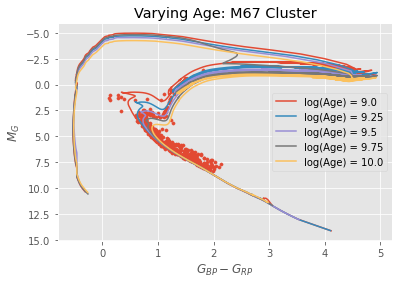

In [743]:
isocmd = isocmd_list[4]
for i in np.linspace(9.0, 10.0, 5):
    age_ind = isocmd.age_index(i) #returns the index for the desired age
    G = isocmd.isocmds[age_ind]['Gaia_G_EDR3']
    B = isocmd.isocmds[age_ind]['Gaia_BP_EDR3']
    V = isocmd.isocmds[age_ind]['Gaia_RP_EDR3']
    plt.plot(B-V, G, label = f"log(Age) = {i}") 
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 10)
plt.title("Varying Age: M67 Cluster")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.legend()
plt.gca().invert_yaxis()
plt.savefig("age_mist_m67", bbox_inches = 'tight')

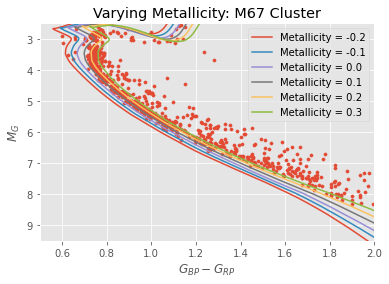

In [744]:
for i in range(6):
    isocmd = isocmd_list[i]
    age_ind = isocmd.age_index(9.5) #returns the index for the desired age
    G = isocmd.isocmds[age_ind]['Gaia_G_EDR3']
    B = isocmd.isocmds[age_ind]['Gaia_BP_EDR3']
    V = isocmd.isocmds[age_ind]['Gaia_RP_EDR3']
    plt.plot(B-V, G, label = f"Metallicity = {round(-0.2 + i/10, 1)}") 
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 10)
plt.title("Varying Metallicity: M67 Cluster")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.xlim((0.5, 2))
plt.ylim((9.5, 2.5))
plt.legend()
plt.savefig("metal_mist_m67", bbox_inches = 'tight')

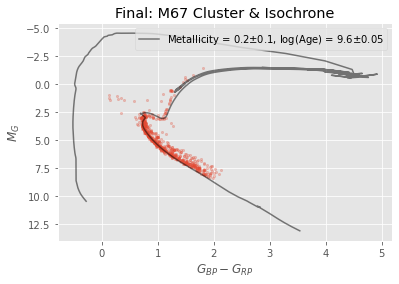

In [745]:
isocmd = isocmd_list[-2]
age = 9.6
age_ind = isocmd.age_index(age)
G = isocmd.isocmds[age_ind]['Gaia_G_EDR3']
B = isocmd.isocmds[age_ind]['Gaia_BP_EDR3']
V = isocmd.isocmds[age_ind]['Gaia_RP_EDR3']
plt.plot(B-V, G, label = f"Metallicity = {round(0.2, 1)}$\pm$0.1, log(Age) = {age}$\pm$0.05", c = "k", alpha = 0.5) 
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 6, alpha = 0.3)
plt.title("Final: M67 Cluster & Isochrone")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.gca().invert_yaxis()
plt.legend()
plt.savefig("mist_m67", bbox_inches = 'tight')

In [746]:
from astropy.table import Table
parsec_iso = Table.read('parsec_m67.txt', format='ascii', header_start=14)
parsec_iso = parsec_iso[(parsec_iso["G_BPmag"]-parsec_iso["G_RPmag"] >= 2) | (parsec_iso["Gmag"] <= 25)]

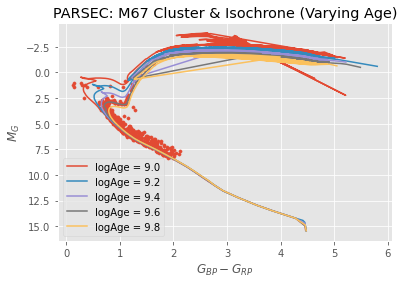

In [747]:
for i in pd.Series(parsec_iso["logAge"]).unique()[::2]:
    z_parsec = parsec_iso[(parsec_iso["Zini"] ==  pd.Series(parsec_iso["Zini"]).unique()[2]) & (parsec_iso["logAge"] == i)]
    plt.plot(z_parsec["G_BPmag"]-z_parsec["G_RPmag"], z_parsec["Gmag"], label = f"logAge = {np.round(i, 2)}")
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 10)
plt.title("PARSEC: M67 Cluster & Isochrone (Varying Age)")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
#plt.xlim((-1, 6))
#plt.ylim((-3, 18))
plt.legend()
plt.gca().invert_yaxis()
plt.savefig("age_parsec_m67", bbox_inches = 'tight')

In [748]:
pd.Series(parsec_iso["logAge"]).unique()[::2][3]

9.6

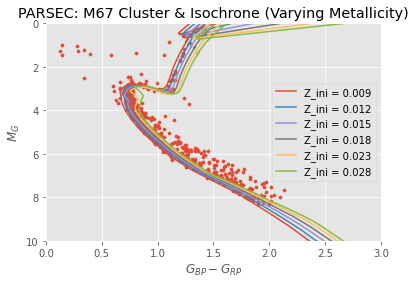

In [749]:
for i in pd.Series(parsec_iso["Zini"]).unique():
    z_parsec = parsec_iso[(parsec_iso["Zini"] == i) & (parsec_iso["logAge"] == 9.6)]
    plt.plot(z_parsec["G_BPmag"]-z_parsec["G_RPmag"], z_parsec["Gmag"], label = f"Z_ini = {np.round(i, 3)}")
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 10)
plt.title("PARSEC: M67 Cluster & Isochrone (Varying Metallicity)")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.xlim((0, 3))
plt.ylim((0, 10))
plt.legend()
plt.gca().invert_yaxis()
plt.savefig("metal_parsec_m67", bbox_inches = 'tight')

In [750]:
pd.Series(parsec_iso["Zini"]).unique()[2]

0.01471

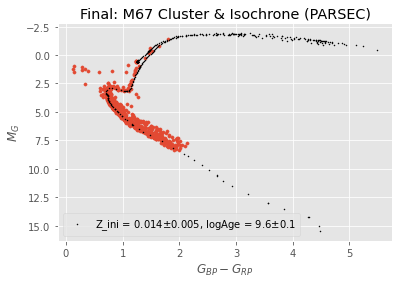

In [751]:
z_parsec = parsec_iso[(parsec_iso["Zini"] == 0.01471) & (parsec_iso["logAge"] == 9.6)]
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 10)
plt.scatter(z_parsec["G_BPmag"]-z_parsec["G_RPmag"], z_parsec["Gmag"], label = f"Z_ini = {0.014}$\pm$0.005, logAge = {9.6}$\pm$0.1", c = "k", s = 1)
plt.title("Final: M67 Cluster & Isochrone (PARSEC)")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.gca().invert_yaxis()
plt.legend()
plt.savefig("parsec_m67", bbox_inches = 'tight')

#0.12

## NGC 6397

**SIMBAD**  
Coordinates : 17 40 42.09 -53 40 27.6  
Proper motions mas/yr : 3.30 -17.60  
Parallaxes (mas): 0.416

Note: I had to remove a parallax error cut in the GAIA Query since it caused me to miss all stars below 
magnitude of 4.

In [781]:
import astropy
import astroquery
import matplotlib.pyplot as plt
from astroquery.utils.tap.core import TapPlus
import pandas as pd
from astropy.coordinates import ICRS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.gaia import Gaia

Gaia.ROW_LIMIT = 10000

max_no = 10000
parallax_lim = [0, 1]
cone_radius = 0.5 # in degrees
co_str = "17:40:42.09 -53:40:27.6"

coord = SkyCoord(co_str, frame='icrs', unit=(u.hourangle, u.deg))


job = Gaia.launch_job_async(
    f"""SELECT TOP {max_no} *, phot_g_mean_mag+5*log10(parallax)-10 as mg, \
    DISTANCE( \
   POINT({coord.ra.degree}, {coord.dec.degree}), \
   POINT(ra, dec)) AS ang_sep \
FROM gaiadr3.gaia_source \
WHERE 1 = CONTAINS( \
   POINT({coord.ra.degree}, {coord.dec.degree}), \
   CIRCLE(ra, dec, {cone_radius})) \
AND parallax > {parallax_lim[0]} \
AND parallax < {parallax_lim[1]} \
AND phot_g_mean_flux_over_error>50 \
AND phot_rp_mean_flux_over_error>20 \
AND phot_bp_mean_flux_over_error>20 \
AND visibility_periods_used>8
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5) < 1.44 * greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
AND astrometric_excess_noise < 1
ORDER BY ang_sep ASC;""", dump_to_file=False)

job2 = Gaia.launch_job_async(
    f"""SELECT TOP {max_no} *, phot_g_mean_mag+5*log10(parallax)-10 as mg, \
    DISTANCE( \
   POINT({coord.ra.degree}, {coord.dec.degree}), \
   POINT(ra, dec)) AS ang_sep \
FROM gaiadr3.gaia_source \
WHERE 1 = CONTAINS( \
   POINT({coord.ra.degree}, {coord.dec.degree}), \
   CIRCLE(ra, dec, {cone_radius})) \
AND parallax > {parallax_lim[0]} \
AND parallax < {parallax_lim[1]} \
ORDER BY ang_sep ASC;""", dump_to_file=False)

# NGC 6397 - 17 40 42.09 -53 40 27.6

hyades_stars = job.get_results()
hyades_no_quality = job2.get_results()

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [782]:
print("Total Stars: ", len(hyades_stars))
#print("Total Stars Before Quality Cuts: ", len(hyades_no_quality))

Total Stars:  10000


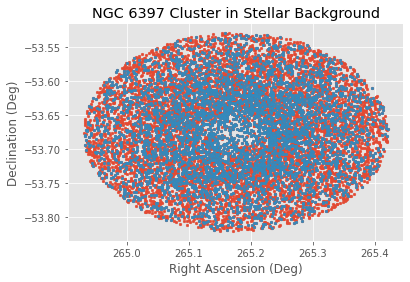

In [783]:
plt.scatter(hyades_stars['ra'], hyades_stars['dec'], s = 7)

para_min = 0.3 #0.32
para_max = 0.47 #0.47
pmra_min = 2
pmra_max = 4.5
pmdec_min = -19
pmdec_max = -16

hyades_parallax = hyades_stars[(hyades_stars['parallax'] > para_min) & (hyades_stars['parallax'] < para_max)]
hyades_pm = hyades_stars[(hyades_stars['pmra'] > pmra_min) & (hyades_stars['pmra'] < pmra_max) 
                         & (hyades_stars['pmdec'] > pmdec_min) & (hyades_stars['pmdec'] < pmdec_max)]
hyades_final = hyades_stars[(hyades_stars['parallax'] > para_min) & (hyades_stars['parallax'] < para_max) & 
                            (hyades_stars['pmra'] > pmra_min) & (hyades_stars['pmra'] < pmra_max) &
                            (hyades_stars['pmdec'] > pmdec_min) & (hyades_stars['pmdec'] < pmdec_max)
                              ]
hyades_noq_final = hyades_no_quality[(hyades_no_quality['parallax'] > para_min) & (hyades_no_quality['parallax'] < para_max) & 
                            (hyades_no_quality['pmra'] > pmra_min) & (hyades_no_quality['pmra'] < pmra_max) &
                            (hyades_no_quality['pmdec'] > pmdec_min) & (hyades_no_quality['pmdec'] < pmdec_max)
                              ]
plt.scatter(hyades_final['ra'], hyades_final['dec'], s = 7)
plt.title("NGC 6397 Cluster in Stellar Background")
plt.xlabel("Right Ascension (Deg)")
plt.ylabel("Declination (Deg)")
plt.savefig("onsky_ngc", bbox_inches = 'tight')

In [784]:
" & ".join(str(x) for x in ["NGC 6397"] + co_str.split(" ") + [cone_radius] + [parallax_lim] + [[para_min, para_max]] + [[pmra_min, pmra_max]] + [[pmdec_min, pmdec_max]]) + "\\"

'NGC 6397 & 17:40:42.09 & -53:40:27.6 & 0.5 & [0, 1] & [0.3, 0.47] & [2, 4.5] & [-19, -16]\\'

In [785]:
len(hyades_final)

4209

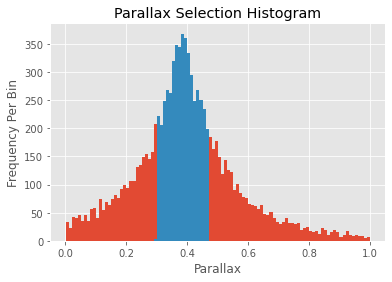

In [786]:
bins = plt.hist(hyades_stars['parallax'], bins = 100)
plt.hist(hyades_parallax['parallax'], bins = bins[1])
plt.title("Parallax Selection Histogram")
plt.xlabel("Parallax")
plt.ylabel("Frequency Per Bin")
plt.savefig("para_ngc", bbox_inches = 'tight')

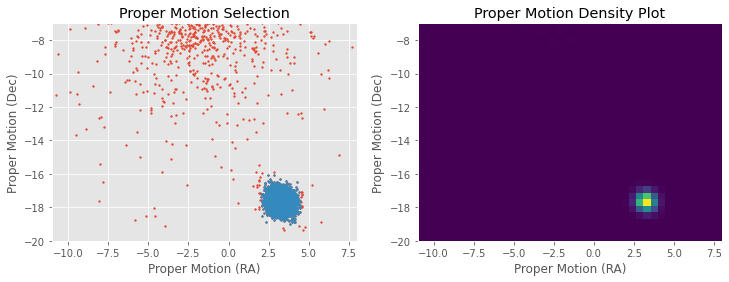

In [787]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].scatter(hyades_stars['pmra'],hyades_stars['pmdec'], s = 3)
ax[0].scatter(hyades_pm['pmra'], hyades_pm['pmdec'], s = 3)
ax[0].set_title("Proper Motion Selection")
ax[0].set_xlabel("Proper Motion (RA)")
ax[0].set_ylabel("Proper Motion (Dec)")
ax[0].set_xlim((-11, 8))
ax[0].set_ylim((-20, -7))
ax[1].hist2d(hyades_stars['pmra'],hyades_stars['pmdec'], bins = 100)
ax[1].sharey(ax[0])
ax[1].sharex(ax[0])
ax[1].set_title("Proper Motion Density Plot")
ax[1].set_xlabel("Proper Motion (RA)")
ax[1].set_ylabel("Proper Motion (Dec)")
plt.savefig("pm_ngc", bbox_inches = 'tight')

In [788]:
print("Total Stars Post All Cuts: ", len(hyades_final))

Total Stars Post All Cuts:  4209


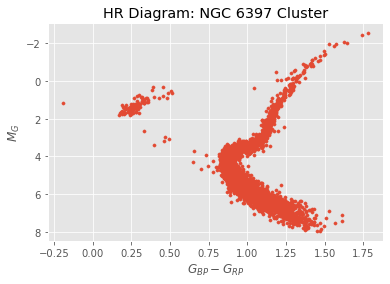

In [789]:
plt.style.use('ggplot')
#plt.scatter(hyades_noq_final['bp_g'] - hyades_noq_final['g_rp'], hyades_noq_final['mg'], s = 10)
#plt.scatter(hyades_final['bp_g'] - hyades_final['g_rp'], hyades_final['mg'], s = 10)
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 10)
plt.gca().invert_yaxis()
plt.title("HR Diagram: NGC 6397 Cluster")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.savefig("hr_ngc", bbox_inches = 'tight')

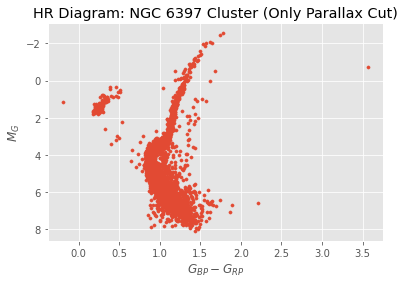

In [790]:
plt.style.use('ggplot')
#plt.scatter(hyades_noq_final['bp_g'] - hyades_noq_final['g_rp'], hyades_noq_final['mg'], s = 10)
plt.scatter(hyades_parallax['bp_rp'], hyades_parallax['mg'], s = 10)
plt.gca().invert_yaxis()
plt.title("HR Diagram: NGC 6397 Cluster (Only Parallax Cut)")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.savefig("hr_noquality_ngc", bbox_inches = 'tight')

In [791]:
import read_mist_models
import matplotlib.pyplot as plt
import numpy as np

isocmd_list = []
for i in np.round(np.arange(-2.2, -1.6, 0.1), 1):
    isocmd_list.append(read_mist_models.ISOCMD(f'ngc_m{i}.iso.cmd'))

Reading in: ngc_m-2.2.iso.cmd
Reading in: ngc_m-2.1.iso.cmd
Reading in: ngc_m-2.0.iso.cmd
Reading in: ngc_m-1.9.iso.cmd
Reading in: ngc_m-1.8.iso.cmd
Reading in: ngc_m-1.7.iso.cmd
Reading in: ngc_m-1.6.iso.cmd


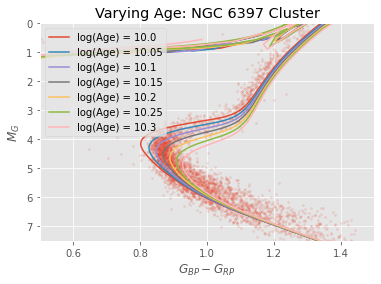

In [792]:
isocmd = isocmd_list[4]
for i in np.round(np.arange(10.0, 10.3, 0.05), 2):
    age_ind = isocmd.age_index(i) #returns the index for the desired age
    G = isocmd.isocmds[age_ind]['Gaia_G_EDR3']
    B = isocmd.isocmds[age_ind]['Gaia_BP_EDR3']
    V = isocmd.isocmds[age_ind]['Gaia_RP_EDR3']
    plt.plot(B-V, G, label = f"log(Age) = {i}") 
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 4, alpha = 0.15)
plt.title("Varying Age: NGC 6397 Cluster")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.xlim((0.5, 1.5))
plt.ylim((0, 7.5))
plt.legend()
plt.gca().invert_yaxis()
plt.savefig("age_mist_ngc", bbox_inches = 'tight')

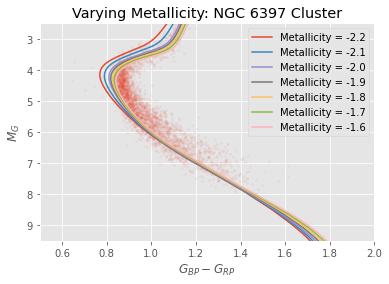

In [793]:
for i in range(7):
    isocmd = isocmd_list[i]
    age_ind = isocmd.age_index(10.05) #returns the index for the desired age
    G = isocmd.isocmds[age_ind]['Gaia_G_EDR3']
    B = isocmd.isocmds[age_ind]['Gaia_BP_EDR3']
    V = isocmd.isocmds[age_ind]['Gaia_RP_EDR3']
    plt.plot(B-V, G, label = f"Metallicity = {round(-2.2 + i/10, 1)}") 
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 4, alpha = 0.06)
plt.title("Varying Metallicity: NGC 6397 Cluster")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.xlim((0.5, 2))
plt.ylim((9.5, 2.5))
plt.legend()
#plt.gca().invert_yaxis()
plt.savefig("metal_mist_ngc", bbox_inches = 'tight')

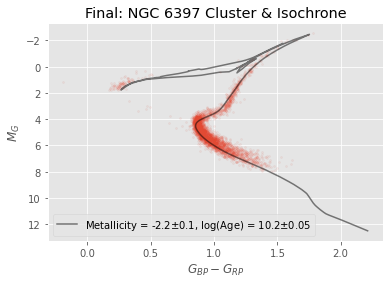

In [768]:
isocmd = isocmd_list[0]
age = 10.2
age_ind = isocmd.age_index(age)
G = isocmd.isocmds[age_ind]['Gaia_G_EDR3']
B = isocmd.isocmds[age_ind]['Gaia_BP_EDR3']
V = isocmd.isocmds[age_ind]['Gaia_RP_EDR3']
plt.plot(B-V, G, label = f"Metallicity = {round(-2.2, 1)}$\pm$0.1, log(Age) = {age}$\pm$0.05", c = "k", alpha = 0.5) 
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 4, alpha = 0.08)
plt.title("Final: NGC 6397 Cluster & Isochrone")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.gca().invert_yaxis()
plt.legend()
plt.savefig("mist_ngc", bbox_inches = 'tight')

In [769]:
from astropy.table import Table
parsec_iso = Table.read('parsec_ngc.txt', format='ascii', header_start=14)
parsec_iso = parsec_iso[(parsec_iso["G_BPmag"]-parsec_iso["G_RPmag"] >= 2) | (parsec_iso["Gmag"] <= 25)]

In [770]:
pd.Series(parsec_iso["logAge"]).unique()[::2]

array([ 9.5,  9.7,  9.9, 10.1, 10.3])

In [771]:
pd.Series(parsec_iso["Zini"]).unique()

array([7.7942e-05, 9.8116e-05, 1.2351e-04, 1.5547e-04, 1.9570e-04,
       2.4632e-04, 3.1003e-04, 3.9019e-04])

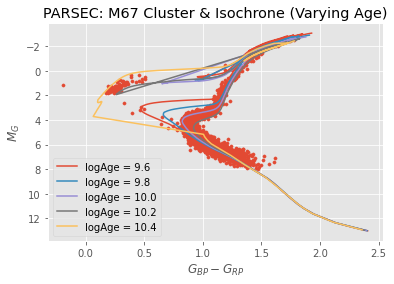

In [772]:
for i in pd.Series(parsec_iso["logAge"]).unique()[1::2]:
    z_parsec = parsec_iso[(parsec_iso["Zini"] ==  pd.Series(parsec_iso["Zini"]).unique()[2]) & (parsec_iso["logAge"] == i)]
    plt.plot(z_parsec["G_BPmag"]-z_parsec["G_RPmag"], z_parsec["Gmag"], label = f"logAge = {np.round(i, 2)}")
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 10)
plt.title("PARSEC: M67 Cluster & Isochrone (Varying Age)")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
#plt.xlim((-1, 6))
#plt.ylim((-3, 18))
plt.legend()
plt.gca().invert_yaxis()
plt.savefig("age_parsec_ngc", bbox_inches = 'tight')

In [773]:
pd.Series(parsec_iso["logAge"]).unique()[::2][3]

10.1

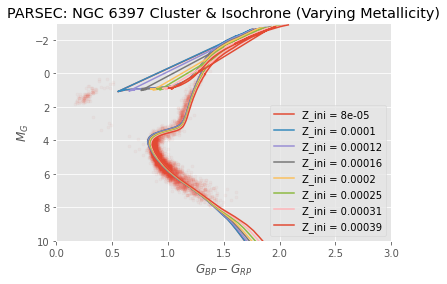

In [794]:
for i in pd.Series(parsec_iso["Zini"]).unique():
    z_parsec = parsec_iso[(parsec_iso["Zini"] == i) & (parsec_iso["logAge"] == 10.0)]
    plt.plot(z_parsec["G_BPmag"]-z_parsec["G_RPmag"], z_parsec["Gmag"], label = f"Z_ini = {np.round(i, 5)}")
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 10, alpha = 0.04)
plt.title("PARSEC: NGC 6397 Cluster & Isochrone (Varying Metallicity)")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.xlim((0, 3))
plt.ylim((-3, 10))
plt.legend()
plt.gca().invert_yaxis()
plt.savefig("metal_parsec_ngc", bbox_inches = 'tight')

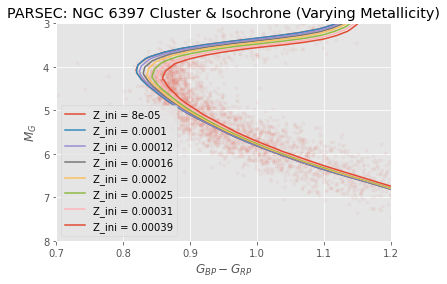

In [795]:
for i in pd.Series(parsec_iso["Zini"]).unique():
    z_parsec = parsec_iso[(parsec_iso["Zini"] == i) & (parsec_iso["logAge"] == 10.0)]
    plt.plot(z_parsec["G_BPmag"]-z_parsec["G_RPmag"], z_parsec["Gmag"], label = f"Z_ini = {np.round(i, 5)}")
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 10, alpha = 0.04)
plt.title("PARSEC: NGC 6397 Cluster & Isochrone (Varying Metallicity)")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.xlim((0.7, 1.2))
plt.ylim((3, 8))
plt.legend()
plt.gca().invert_yaxis()
plt.savefig("metal_parsec_ngc", bbox_inches = 'tight')

In [776]:
pd.Series(parsec_iso["Zini"]).unique()[6]

0.00031003

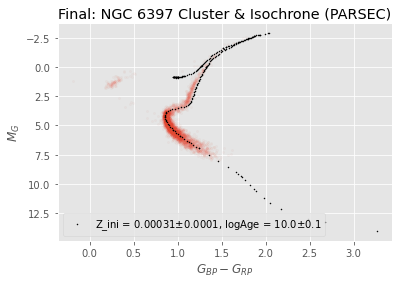

In [796]:
z_parsec = parsec_iso[(parsec_iso["Zini"] == 0.00031003) & (parsec_iso["logAge"] == 10.0)]
plt.scatter(hyades_final['bp_rp'], hyades_final['mg'], s = 4, alpha = 0.04)
plt.scatter(z_parsec["G_BPmag"]-z_parsec["G_RPmag"], z_parsec["Gmag"], label = f"Z_ini = {3.1e-4}$\pm$0.0001, logAge = {10.0}$\pm$0.1", c = "k", s = 1)
plt.title("Final: NGC 6397 Cluster & Isochrone (PARSEC)")
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$M_G$")
plt.gca().invert_yaxis()
plt.legend()
plt.savefig("parsec_ngc", bbox_inches = 'tight')

In [ ]:
#0.682